In [1]:
import os
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from receptive_field import receptive_field, receptive_field_for_unit
from small2DNet import small2DNet
from small3DNet import small3DNet
from colorMNist import colorMNist
from util import add_color, colorize, colorize_gaussian, calculate_correct_loss
import random
import colorsys
import pickle

In [2]:
model_layers = [8, 8, "M", 16,"M"]
linear_neurons = 512
model = small2DNet(model_layers, 16, linear_neurons)
model.load_state_dict(torch.load('model_saves/2D/Gaussian2D_36.pth'))
model.cuda()
model = model.features

cl_model = small2DNet(model_layers, 16, linear_neurons)
cl_model.load_state_dict(torch.load('model_saves/2D/Gaussian2D_36.pth'))
cl_model.cuda()
cl_model = cl_model.features

In [3]:
model = model[:2]
cl_model = cl_model[:2]
print(model)

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)


In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cl_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cmnist_train, cmnist_val, cmnist_test = pickle.load(open("custom_datasets/cmnist_deterministic.pkl", "rb"))
test_dataset = colorMNist(cmnist_test)
cmnist_train, cmnist_val, colorless_test = pickle.load(open("custom_datasets/cmnist_colorless.pkl", "rb"))
cl_dataset = colorMNist(colorless_test)

# test_dataset = torchvision.datasets.CIFAR10(root='datasets/cifar10', train=False, download=False, transform=transform)
# cl_dataset = torchvision.datasets.CIFAR10(root='datasets/cifar10', train=False, download=False, transform=cl_transform)

mean = np.asarray([0.1307, 0.1307, 0.1307])
std = np.asarray([0.3081, 0.3081, 0.3081])
# mean = np.asarray([0.5, 0.5, 0.5])
# std = np.asarray([0.5, 0.5, 0.5])
mtype=len(model[0].kernel_size)

In [7]:
def get_neuron_features(model, dataset, max_activations, batch_size=32, top_n=100, 
                        out_dir='./NFResults',mean=[0,0,0], std=[1,1,1], mtype=2):
    """
    Generates neuron features for given model definition using given dataset.
    :param model: Pytorch model definition.
    :param dataset: Dataset used for generating NFs.
    :param batch_size: Batch size used for predicting feature maps.
    :top_n: Use top_n input patch activations for generating NF.
    :out_dir: Directory where generated images are stored.
    :mean: Dataset mean used for normalization in transform function.
    :std: Dataset std used for normalization in transform function.
    
    :return: returns nothing
    """

    # make output directory of not exists
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # set model in eval mode
    if torch.cuda.is_available():
        model = model.cuda()

    # Set model in eval mode
    model.eval()

    # Dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                   shuffle=False, num_workers = 0)
    mean = np.asarray(mean)
    std = np.asarray(std)

    # input shape (c,w,h)
    in_shape = next(iter(dataloader))[0].unsqueeze(1).shape[1:] if mtype == 3 else next(iter(dataloader))[0].shape[1:]
    # receptive field info for entire model
    receptive_field_dict = receptive_field(model, in_shape)
    # output layer info
    output_layer_info = receptive_field_dict[str(list(receptive_field_dict.keys())[-2])]
    # check if fm has group convs
    fm_groups = output_layer_info['output_shape'][2] if len(output_layer_info['output_shape']) == 5 else 0
    # number of filters in last fm
    n_filters = output_layer_info['output_shape'][1]
    
    # Create placeholder for input patches
    rf = int(output_layer_info['r'])
    
    if fm_groups > 0:
        fm_im = np.zeros((top_n,n_filters,fm_groups,rf,rf,3))
        fm_w = -1e5*np.ones((top_n,n_filters,fm_groups))
    else:
        fm_im = np.zeros((top_n,n_filters,rf,rf,3))
        fm_w = -1e5*np.ones((top_n,n_filters))

    # Calculate amount of padding needed for input visualization
    # Get range for rf at position 0,0 in final feature map
    rf_range = receptive_field_for_unit(receptive_field_dict, str(list(receptive_field_dict.keys())[-2]), (0,0))
    pad_y = int(rf-(rf_range[0][1]-rf_range[0][0]))
    pad_x = int(rf-(rf_range[1][1]-rf_range[1][0]))
    
    
    # Print summary
    print('Group Convolutions: \t {}, {} elements'.format(fm_groups>0, fm_groups))
    print('Number of filters: \t {}'.format(n_filters))
    print('Receptive field size: \t {}'.format(rf))
    print('RF range at (0,0): \t {}'.format(rf_range))
    print('Input padding (x,y): \t {}, {}'.format(pad_x, pad_y))
    print('==============================================================================')

    # Iterate over all data samples to get input patch for highest neuron activation
    # for each filter and transformation
    with torch.no_grad():
        ids = 0
        for inputs, labels in tqdm(dataloader, total=len(dataloader), desc='Extracting input patches: '):
            if torch.cuda.is_available():
                model_inputs = inputs.cuda()
            else:
                model_inputs = inputs
                
            # Add extra dimension for the network
            if mtype == 3:
                model_inputs = model_inputs.unsqueeze(1)

            # Predict feature map
            fm = model(model_inputs)

            # Convert inputs to numpy w,h,c for visualization
            inputs = inputs.permute((0,2,3,1)).numpy()
            # Unnormalize
            inputs *= std[None,None,None,:]
            inputs += mean[None,None,None,:]
            inputs = np.clip(inputs,0,1)
            # Pad inputs for visualization to compensate for padding in layers
            inputs = np.pad(inputs, ((0,0),(pad_y,pad_y),(pad_x,pad_x),(0,0)), mode='constant')

            # get batch shape
            fm_shape = fm.shape
            # if gconv: reshape groups into channels
            if fm_groups > 0:
                fm = fm.view((fm_shape[0],-1,fm_shape[3],fm_shape[4]))

            # Get max values and locations of feature maps
            # pool size = fm size = fm_shape[-1]
            a, b = F.max_pool2d(fm, (fm_shape[-2],fm_shape[-1]), return_indices=True)

            # if gconv: reshape groups back to own dimension
            if fm_groups > 0:
                a = a.view((fm_shape[0],fm_shape[1],fm_shape[2]))
                b = b.view((fm_shape[0],fm_shape[1],fm_shape[2]))

            a = a.cpu().numpy()
            b = b.cpu().numpy()

            # coordinates of max activations
            x = b % fm.shape[-1]
            y = b // fm.shape[-1]

            # store weight and input patches for each max position
            for i in range(inputs.shape[0]):
                for j in range(n_filters):

                    if fm_groups == 0:
                        # check if weight is higher than current lowest weight
                        if a[i,j] > np.min(fm_w[:,j]):
                            # replace lowest weight by current weight
                            m = np.argmin(fm_w[:,j])
                            fm_w[m,j] = a[i,j]
                            # save indices
                            max_activations[j].append(ids)
                            # store input patch
                            rf_range = receptive_field_for_unit(receptive_field_dict, str(list(receptive_field_dict.keys())[-2]), (y[i,j],x[i,j]), bound=False)
                            fm_im[m,j,:,:,:] = inputs[i,rf_range[0][0]+pad_y:rf_range[0][1]+pad_y,rf_range[1][0]+pad_x:rf_range[1][1]+pad_x,:]

                    else:
                        # loop over extra dimension for gconv
                        for k in range(fm_groups):
                            # check if weight is higher than current lowest weight
                            if a[i,j,k] > np.min(fm_w[:,j,k]):
                                # replace lowest weight by current weight
                                m = np.argmin(fm_w[:,j,k])
                                # store weight
                                fm_w[m,j,k] = a[i,j,k]
                                # save indices
                                max_activations[k][j].append(ids)
                                # store input patch
                                rf_range = receptive_field_for_unit(receptive_field_dict, str(list(receptive_field_dict.keys())[-2]), (y[i,j,k],x[i,j,k]), bound=False)
                                fm_im[m,j,k,:,:,:] = inputs[i,rf_range[0][0]+pad_y:rf_range[0][1]+pad_y,rf_range[1][0]+pad_x:rf_range[1][1]+pad_x,:]
                ids += 1
    # Calculate and save neuron feature for each filter and transformation
    for i in tqdm(range(n_filters), total=n_filters, desc='Generating neuron features: '):
        if fm_groups == 0:
            w_sum = np.sum(fm_w[:,i])
            if w_sum > 0:
                # Sort patches in order of highest neuron activations
                idx = np.argsort(fm_w[:,i])[::-1] # ::-1 for high to low sort
                fm_w[:,i] = fm_w[idx,i]
                fm_im[:,i,:,:,:] = fm_im[idx,i,:,:,:]

                # Calculate neuron feature
                fm_nfw = fm_w[:,i,None,None,None]/w_sum
                nf = np.sum(fm_im[:,i,:,:,:]*fm_nfw, axis=0)

                # Plot 19 highest activated patches
                plt.figure(figsize=(40,2))
                for j in range(19):
                    plt.subplot(1,20,j+2)
                    plt.title('{:.3f}'.format(fm_w[j,i]))
                    plt.imshow(fm_im[j,i,:,:,:])
                # Plot NF
                plt.subplot(1,20,1)
                plt.imshow(nf)
                plt.title('NF')
                _=plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
                plt.savefig(os.path.join(out_dir,'f_{:02d}.png'.format(i)), bbox_inches='tight')
                # plt.savefig(os.path.join(out_dir,'f_{:02d}.pdf'.format(i)), bbox_inches='tight')
                plt.close()

        else:
            plt.figure(figsize=(40,6))
            for k in range(fm_groups):
                w_sum = np.sum(fm_w[:,i,k])
                if w_sum > 0:
                    # Sort patches in order of highest neuron activations
                    idx = np.argsort(fm_w[:,i,k])[::-1] # ::-1 for high to low sort
                    fm_w[:,i,k] = fm_w[idx,i,k]
                    fm_im[:,i,k,:,:,:] = fm_im[idx,i,k,:,:,:]

                    # Calculate neuron feature
                    fm_nfw = fm_w[:,i,k,None,None,None]/w_sum
                    nf = np.sum(fm_im[:,i,k,:,:,:]*fm_nfw, axis=0)

                    # Plot 19 highest activated patches
                    for j in range(19):
                        plt.subplot(fm_groups,20,j+2+20*k)
                        plt.title('{:.3f}'.format(fm_w[j,i,k]))
                        plt.imshow(fm_im[j,i,k,:,:,:])
                    # Plot NF
                    plt.subplot(fm_groups,20,1+20*k)
                    plt.imshow(nf)
                    plt.title('NF')
            _=plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
            plt.savefig(os.path.join(out_dir,'f_{:02d}.png'.format(i)), bbox_inches='tight')
            # plt.savefig(os.path.join(out_dir,'f_{:02d}.pdf'.format(i)), bbox_inches='tight')
            plt.close()
    print('Done!')
    
    return max_activations, fm_w

In [8]:
def colorless_get_neuron_features(model, dataset, activation_indices, indices, batch_size=32, top_n=100, 
                        out_dir='./NFResults',mean=[0,0,0], std=[1,1,1], mtype=2):
    """
    Generates neuron features for given model definition using given dataset.
    :param model: Pytorch model definition.
    :param dataset: Dataset used for generating NFs.
    :param batch_size: Batch size used for predicting feature maps.
    :top_n: Use top_n input patch activations for generating NF.
    :out_dir: Directory where generated images are stored.
    :mean: Dataset mean used for normalization in transform function.
    :std: Dataset std used for normalization in transform function.
    
    :return: returns nothing
    """

    # make output directory of not exists
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # set model in eval mode
    if torch.cuda.is_available():
        model = model.cuda()

    # Set model in eval mode
    model.eval()

    # Dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                   shuffle=False, num_workers = 0)
    mean = np.asarray(mean)
    std = np.asarray(std)

    # input shape (c,w,h)
    in_shape = next(iter(dataloader))[0].unsqueeze(1).shape[1:] if mtype == 3 else next(iter(dataloader))[0].shape[1:]
    # receptive field info for entire model
    receptive_field_dict = receptive_field(model, in_shape)
    # output layer info
    output_layer_info = receptive_field_dict[str(list(receptive_field_dict.keys())[-2])]
    # check if fm has group convs
    fm_groups = output_layer_info['output_shape'][2] if len(output_layer_info['output_shape']) == 5 else 0
    # number of filters in last fm
    n_filters = output_layer_info['output_shape'][1]
    
    # Create placeholder for input patches
    rf = int(output_layer_info['r'])
    
    if fm_groups > 0:
        fm_im = np.zeros((top_n,n_filters,fm_groups,rf,rf,3))
        fm_w = -1e5*np.ones((top_n,n_filters,fm_groups))
    else:
        fm_im = np.zeros((top_n,n_filters,rf,rf,3))
        fm_w = -1e5*np.ones((top_n,n_filters))

    # Calculate amount of padding needed for input visualization
    # Get range for rf at position 0,0 in final feature map
    rf_range = receptive_field_for_unit(receptive_field_dict, str(list(receptive_field_dict.keys())[-2]), (0,0))
    pad_y = int(rf-(rf_range[0][1]-rf_range[0][0]))
    pad_x = int(rf-(rf_range[1][1]-rf_range[1][0]))
    
    
    # Print summary
    print('Group Convolutions: \t {}, {} elements'.format(fm_groups>0, fm_groups))
    print('Number of filters: \t {}'.format(n_filters))
    print('Receptive field size: \t {}'.format(rf))
    print('RF range at (0,0): \t {}'.format(rf_range))
    print('Input padding (x,y): \t {}, {}'.format(pad_x, pad_y))
    print('==============================================================================')

    # Iterate over all data samples to get input patch for highest neuron activation
    # for each filter and transformation
    with torch.no_grad():
        ids = 0
        for inputs, labels in tqdm(dataloader, total=len(dataloader), desc='Extracting input patches: '):
            if torch.cuda.is_available():
                model_inputs = inputs.cuda()
            else:
                model_inputs = inputs
                
            # Add extra dimension for the network
            if mtype == 3:
                model_inputs = model_inputs.unsqueeze(1)
                
            # Predict feature map
            fm = model(model_inputs)

            # Convert inputs to numpy w,h,c for visualization
            inputs = inputs.permute((0,2,3,1)).numpy()
            # Unnormalize
            inputs *= std[None,None,None,:]
            inputs += mean[None,None,None,:]
            inputs = np.clip(inputs,0,1)
            # Pad inputs for visualization to compensate for padding in layers
            inputs = np.pad(inputs, ((0,0),(pad_y,pad_y),(pad_x,pad_x),(0,0)), mode='constant')

            # get batch shape
            fm_shape = fm.shape
            # if gconv: reshape groups into channels
            if fm_groups > 0:
                fm = fm.view((fm_shape[0],-1,fm_shape[3],fm_shape[4]))

            # Get max values and locations of feature maps
            # pool size = fm size = fm_shape[-1]
            a, b = F.max_pool2d(fm, (fm_shape[-2],fm_shape[-1]), return_indices=True)

            # if gconv: reshape groups back to own dimension
            if fm_groups > 0:
                a = a.view((fm_shape[0],fm_shape[1],fm_shape[2]))
                b = b.view((fm_shape[0],fm_shape[1],fm_shape[2]))

            a = a.cpu().numpy()
            b = b.cpu().numpy()

            # coordinates of max activations
            x = b % fm.shape[-1]
            y = b // fm.shape[-1]

            # store weight and input patches for each max position
            for i in range(inputs.shape[0]):
                for j in range(n_filters):

                    if fm_groups == 0:
                        # check if weight is higher than current lowest weight
                        if ids in indices[j][-100:]:
                        # if a[i,j] > np.min(fm_w[:,j]):
                            # replace lowest weight by current weight
                            m = np.argmin(fm_w[:,j])
                            activation_indices[j].append(ids)
                            fm_w[m,j] = a[i,j]
                            # store input patch
                            rf_range = receptive_field_for_unit(receptive_field_dict, str(list(receptive_field_dict.keys())[-2]), (y[i,j],x[i,j]), bound=False)
                            fm_im[m,j,:,:,:] = inputs[i,rf_range[0][0]+pad_y:rf_range[0][1]+pad_y,rf_range[1][0]+pad_x:rf_range[1][1]+pad_x,:]

                    else:
                        # loop over extra dimension for gconv
                        for k in range(fm_groups):
                            # check if weight is higher than current lowest weight
                            if ids in indices[k][j][-100:]:
                            # if a[i,j,k] > np.min(fm_w[:,j,k]):
                                # replace lowest weight by current weight
                                m = np.argmin(fm_w[:,j,k])
                                # save index
                                activation_indices[k][j].append(ids)
                                # store weight
                                fm_w[m,j,k] = a[i,j,k]
                                # store input patch
                                rf_range = receptive_field_for_unit(receptive_field_dict, str(list(receptive_field_dict.keys())[-2]), (y[i,j,k],x[i,j,k]), bound=False)
                                fm_im[m,j,k,:,:,:] = inputs[i,rf_range[0][0]+pad_y:rf_range[0][1]+pad_y,rf_range[1][0]+pad_x:rf_range[1][1]+pad_x,:]
                ids += 1
    # Calculate and save neuron feature for each filter and transformation
    for i in tqdm(range(n_filters), total=n_filters, desc='Generating neuron features: '):
        if fm_groups == 0:
            w_sum = np.sum(fm_w[:,i])
            if w_sum > 0:
                # Sort patches in order of highest neuron activations
                idx = np.argsort(fm_w[:,i])[::-1] # ::-1 for high to low sort
                fm_w[:,i] = fm_w[idx,i]
                fm_im[:,i,:,:,:] = fm_im[idx,i,:,:,:]

                # Calculate neuron feature
                fm_nfw = fm_w[:,i,None,None,None]/w_sum
                nf = np.sum(fm_im[:,i,:,:,:]*fm_nfw, axis=0)

                # Plot 19 highest activated patches
                plt.figure(figsize=(40,2))
                for j in range(19):
                    plt.subplot(1,20,j+2)
                    plt.title('{:.3f}'.format(fm_w[j,i]))
                    plt.imshow(fm_im[j,i,:,:,:])
                # Plot NF
                plt.subplot(1,20,1)
                plt.imshow(nf)
                plt.title('NF')
                _=plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
                plt.savefig(os.path.join(out_dir,'f_{:02d}.png'.format(i)), bbox_inches='tight')
                # plt.savefig(os.path.join(out_dir,'f_{:02d}.pdf'.format(i)), bbox_inches='tight')
                plt.close()

        else:
            plt.figure(figsize=(40,6))
            for k in range(fm_groups):
                w_sum = np.sum(fm_w[:,i,k])
                if w_sum > 0:
                    # Sort patches in order of highest neuron activations
                    idx = np.argsort(fm_w[:,i,k])[::-1] # ::-1 for high to low sort
                    fm_w[:,i,k] = fm_w[idx,i,k]
                    fm_im[:,i,k,:,:,:] = fm_im[idx,i,k,:,:,:]

                    # Calculate neuron feature
                    fm_nfw = fm_w[:,i,k,None,None,None]/w_sum
                    nf = np.sum(fm_im[:,i,k,:,:,:]*fm_nfw, axis=0)

                    # Plot 19 highest activated patches
                    for j in range(19):
                        plt.subplot(fm_groups,20,j+2+20*k)
                        plt.title('{:.3f}'.format(fm_w[j,i,k]))
                        plt.imshow(fm_im[j,i,k,:,:,:])
                    # Plot NF
                    plt.subplot(fm_groups,20,1+20*k)
                    plt.imshow(nf)
                    plt.title('NF')
            _=plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
            plt.savefig(os.path.join(out_dir,'f_{:02d}.png'.format(i)), bbox_inches='tight')
            # plt.savefig(os.path.join(out_dir,'f_{:02d}.pdf'.format(i)), bbox_inches='tight')
            plt.close()
    print('Done!')
    
    return activation_indices, fm_w

In [9]:
# 2D        
activations = []
cl_activations = []
c_a = []

for i in range(16):
    activations.append([])
    cl_activations.append([])
    c_a.append([])
    
max_activations, w = get_neuron_features(model, test_dataset, activations, batch_size=32, top_n=100, out_dir='./NFResults/Test/', mean=mean, std=std)
cl_activations, cl_w = colorless_get_neuron_features(cl_model, cl_dataset, cl_activations, max_activations, batch_size=32, top_n=100, out_dir='./NFResults/Test2/', mean=mean, std=std)
c_a, c_w = colorless_get_neuron_features(model, test_dataset, c_a, max_activations, batch_size=32, top_n=100, out_dir='./NFResults/Test3/', mean=mean, std=std)

------------------------------------------------------------------------------
        Layer (type)    map size        start       jump      receptive_field 
        0                 [28, 28]        0.5        1.0             1.0 
        1                 [28, 28]        0.5        1.0             3.0 
        2                 [28, 28]        0.5        1.0             3.0 
        3                 [28, 28]        0.5        1.0             5.0 
        4                 [28, 28]        0.5        1.0             5.0 
        5                 [14, 14]        1.0        2.0             6.0 
        6                 [14, 14]        1.0        2.0            10.0 
        7                 [14, 14]        1.0        2.0            10.0 
        8                   [7, 7]        2.0        4.0            12.0 
Group Convolutions: 	 False, 0 elements
Number of filters: 	 16
Receptive field size: 	 12
RF range at (0,0): 	 [(0, 8), (0, 8)]
Input padding (x,y): 	 4, 4


Generating neuron features: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


Done!
------------------------------------------------------------------------------
        Layer (type)    map size        start       jump      receptive_field 
        0                 [28, 28]        0.5        1.0             1.0 
        1                 [28, 28]        0.5        1.0             3.0 
        2                 [28, 28]        0.5        1.0             3.0 
        3                 [28, 28]        0.5        1.0             5.0 
        4                 [28, 28]        0.5        1.0             5.0 
        5                 [14, 14]        1.0        2.0             6.0 
        6                 [14, 14]        1.0        2.0            10.0 
        7                 [14, 14]        1.0        2.0            10.0 
        8                   [7, 7]        2.0        4.0            12.0 
Group Convolutions: 	 False, 0 elements
Number of filters: 	 16
Receptive field size: 	 12
RF range at (0,0): 	 [(0, 8), (0, 8)]
Input padding (x,y): 	 4, 4


Generating neuron features: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


Done!
------------------------------------------------------------------------------
        Layer (type)    map size        start       jump      receptive_field 
        0                 [28, 28]        0.5        1.0             1.0 
        1                 [28, 28]        0.5        1.0             3.0 
        2                 [28, 28]        0.5        1.0             3.0 
        3                 [28, 28]        0.5        1.0             5.0 
        4                 [28, 28]        0.5        1.0             5.0 
        5                 [14, 14]        1.0        2.0             6.0 
        6                 [14, 14]        1.0        2.0            10.0 
        7                 [14, 14]        1.0        2.0            10.0 
        8                   [7, 7]        2.0        4.0            12.0 
Group Convolutions: 	 False, 0 elements
Number of filters: 	 16
Receptive field size: 	 12
RF range at (0,0): 	 [(0, 8), (0, 8)]
Input padding (x,y): 	 4, 4


Generating neuron features: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

Done!


In [10]:
for i in range(16):
    # print(np.sum(w[:, i]))
    # print(np.sum(cl_w[:, i]))
    # print(np.sum(c_w[:, i]))
    # print("\n")
    print(np.round(1 - (np.sum(cl_w[:, i])) / np.sum(c_w[:, i]), 4))

0.0682
-0.4278
-0.1989
-0.4633
0.5738
0.3502
-0.5424
-0.4431
-0.4586
-0.5871
-0.4328
-0.3563
-0.3549
-0.3824
-0.37
-0.3239


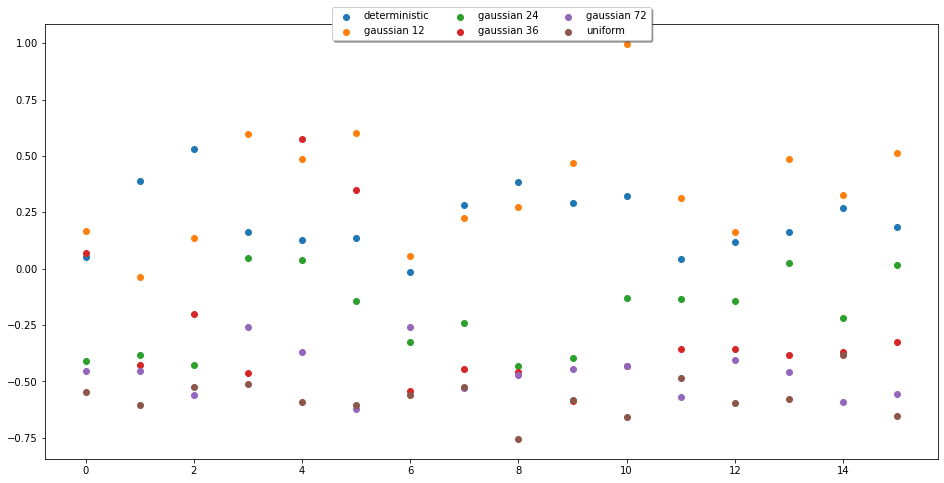

<Figure size 2160x1656 with 0 Axes>

In [18]:
x = [i for i in range(16)]
# plt.scatter(x, [1 for _ in range(16)])
det = [0.052, 0.3887, 0.5325, 0.1642, 0.1285, 0.1383, -0.0124, 0.2835, 0.3871, 0.2901, 0.3219, 0.0447, 0.1185, 0.1646, 0.2708, 0.1855]
g12 = [0.1676, -0.0346, 0.135, 0.6002, 0.4851, 0.6013, 0.0581, 0.2239, 0.2758, 0.4697, 0.9987, 0.3131, 0.1633, 0.4893, 0.3296, 0.5152]
g24 = [-0.4098,-0.3823,-0.4289,0.0477,0.0377,-0.1413,-0.3226,-0.2412,-0.4294,-0.3962,-0.1304,-0.1347,-0.1407,0.0264,-0.2193,0.0151]
g36 = [0.0682,-0.4278,-0.1989,-0.4633,0.5738,0.3502,-0.5424,-0.4431,-0.4586,-0.5871,-0.4328,-0.3563,-0.3549,-0.3824,-0.37,-0.3239]
g72 = [-0.4525,-0.4544,-0.5589,-0.2577,-0.3702,-0.6219,-0.2575,-0.528,-0.4723,-0.4467,-0.4302,-0.5693,-0.4056,-0.4565,-0.593,-0.5546]
uni = [-0.5458,-0.603,-0.5255,-0.5129,-0.5921,-0.6054,-0.5594,-0.5266,-0.7553,-0.5832,-0.6556,-0.4862,-0.5958,-0.5757,-0.3821,-0.6509]

plt.figure(figsize=(16, 8))
plt.scatter(x, det, label="deterministic")
plt.scatter(x, g12, label="gaussian 12")
plt.scatter(x, g24, label="gaussian 24")
plt.scatter(x, g36, label="gaussian 36")
plt.scatter(x, g72, label="gaussian 72")
plt.scatter(x, uni, label="uniform")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.figure(figsize=(30, 23))
plt.show()



In [ ]:
# 3D
activations = []
cl_activations = []
c_a = []

for j in range(3):
    activations.append([])
    cl_activations.append([])
    c_a.append([])
    for i in range(16):
        activations[j].append([])
        cl_activations[j].append([])
        c_a[j].append([])
        
max_activations, w = get_neuron_features(model, test_dataset, activations, batch_size=32, top_n=100, out_dir='./NFResults/Test/', mean=mean, std=std, mtype=mtype)
cl_activations, cl_w = colorless_get_neuron_features(cl_model, cl_dataset, cl_activations, max_activations, batch_size=32, top_n=100, out_dir='./NFResults/Test2/', mean=mean, std=std, mtype=mtype)
c_a, c_w = colorless_get_neuron_features(model, test_dataset, c_a, max_activations, batch_size=32, top_n=100, out_dir='./NFResults/Test3/', mean=mean, std=std, mtype=mtype)

In [ ]:
for i in range(16):
    avg = 0
    for k in range(3):
        # print(np.sum(w[:, i]))
        # print(np.sum(cl_w[:, i]))
        # print(np.sum(c_w[:, i]))
        # print(np.round(1 - (np.sum(cl_w[:, i, k])) / np.sum(c_w[:, i, k]), 4))
        avg += np.round(1 - (np.sum(cl_w[:, i, k])) / np.sum(c_w[:, i, k]), 4)
    
    print(np.round(avg/3, 4))

In [ ]:
csi_3d = [0.2823, 0.2937, 0.3684, 0.5469, 0.076, 0.6448, 0.0707, 0.7025, 0.1377, 0.6089, 0.1217, 0.1245, 0.2913, 0.6147, 0.3888, 0.0625]
csi_2d = [-0.0101, 0.1312, 0.003, 0.0722, 0.0102, -0.001, 0.1987, -0.0048, 0.0046, -0.0033, 0.3337, 0.2284, 0.1583, 0.0278, 0.147, 0.2228]

total = 0
for i in range(len(csi_2d)):
    total += (csi_2d[i] - csi_3d[i])
    
print(np.round(total, 4))